In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
bike_changes_cluster_aggregated = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/bike_changes_cluster_aggregated.csv', low_memory=False)

In [ ]:
# ============================================================
# LOAD SAVED XGBOOST MODEL FROM HYPERPARAMETER SEARCH
# ============================================================
import joblib
import warnings
warnings.filterwarnings('ignore')

# Load the RandomizedSearchCV results
xgb_search = joblib.load('/content/drive/MyDrive/Colab Notebooks/xgboost_search_results.pkl')

# Extract the best model
best_xgb_model = xgb_search.best_estimator_

print("✅ Loaded XGBoost model from xgboost_search_results.pkl")
print("\nBest Parameters from Hyperparameter Search:")
for param, value in xgb_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest CV Score (neg MSE): {xgb_search.best_score_:.4f}")
print(f"Best CV RMSE: {(-xgb_search.best_score_)**0.5:.4f}")

✅ Loaded XGBoost model from xgboost_search_results.pkl

Best Parameters from Hyperparameter Search:
  subsample: 0.6
  reg_lambda: 1.5
  reg_alpha: 0
  n_estimators: 300
  min_child_weight: 1
  max_depth: 9
  learning_rate: 0.05
  gamma: 0.3
  colsample_bytree: 1.0

Best CV Score (neg MSE): -46.9924
Best CV RMSE: 6.8551


In [ ]:
# ============================================================
# PREPARE CLUSTER DATA FOR MODELING
# ============================================================

# Step 1: Clean and sort data FIRST
bike_changes_cluster_aggregated = bike_changes_cluster_aggregated.copy()
bike_changes_cluster_aggregated = bike_changes_cluster_aggregated.dropna()

# IMPORTANT: Sort by time BEFORE creating X and y
bike_changes_cluster_aggregated = bike_changes_cluster_aggregated.sort_values('time_interval')
bike_changes_cluster_aggregated = bike_changes_cluster_aggregated.reset_index(drop=True)

print(f"Data shape after cleaning: {bike_changes_cluster_aggregated.shape}")
print(f"Rows: {len(bike_changes_cluster_aggregated):,}")

# Step 2: Define target
TARGET = 'cumulative_bikes'

# Step 3: Define columns to exclude (identifiers + leakage)
EXCLUDE_COLUMNS = [
    TARGET,  # Target variable
    'geo_cluster',  # Keep as identifier, not feature (or include if you want)
    'time_interval',  # Datetime
    'net_change',  # Leakage - directly related to target
    'cumulative_bikes_lag1',  # Potential leakage - very direct predictor
    'cumulative_bikes_lag2',  # Potential leakage
    'cumulative_bikes_lag4',  # Potential leakage
    'rate_of_change',
    'rate_of_change_lag1'
]

# Step 4: Create X and y from sorted data
X = bike_changes_cluster_aggregated.drop(columns=[col for col in EXCLUDE_COLUMNS if col in bike_changes_cluster_aggregated.columns])
y = bike_changes_cluster_aggregated[TARGET]

# Keep only numeric columns
X = X.select_dtypes(include=['number'])

print(f"\n✅ X shape: {X.shape}")
print(f"✅ y shape: {y.shape}")
print(f"✅ Target range: {y.min():.1f} to {y.max():.1f}")

print(f"\nFeatures being used ({X.shape[1]} total):")
for i, col in enumerate(X.columns, 1):
    print(f"  {i:2}. {col}")

Data shape after cleaning: (24853, 31)
Rows: 24,853

✅ X shape: (24853, 23)
✅ y shape: (24853,)
✅ Target range: -437.0 to 915.0

Features being used (23 total):
   1. hour
   2. day_of_week
   3. is_morning_rush
   4. is_evening_rush
   5. avg_trip_duration
   6. median_trip_duration
   7. electric_bike_count
   8. classic_bike_count
   9. member_count
  10. casual_count
  11. lat
  12. lng
  13. distance_from_center
  14. total_historical_rides
  15. avg_trip_duration_hist
  16. std_trip_duration
  17. member_proportion_hist
  18. temp
  19. windspeed
  20. is_raining
  21. station_count
  22. rolling_mean_4
  23. rolling_std_4


In [ ]:
# ============================================================
# TIME-SERIES TRAIN/VAL/TEST SPLIT (60/20/20)
# ============================================================
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("="*60)
print("TIME-SERIES TRAIN/VAL/TEST SPLIT")
print("="*60)

# Define split ratios
train_pct = 0.6
val_pct = 0.2
test_pct = 0.2

n = len(X)
train_end = int(n * train_pct)
val_end = int(n * (train_pct + val_pct))

print(f"Total samples: {n:,}")
print(f"Split: {train_pct*100:.0f}% train, {val_pct*100:.0f}% val, {test_pct*100:.0f}% test")

# Sequential split (data is already sorted by time)
X_train_cluster = X.iloc[:train_end]
y_train_cluster = y.iloc[:train_end]

X_val_cluster = X.iloc[train_end:val_end]
y_val_cluster = y.iloc[train_end:val_end]

X_test_cluster = X.iloc[val_end:]
y_test_cluster = y.iloc[val_end:]

print(f"\n✅ Train set: {len(X_train_cluster):,} samples ({len(X_train_cluster)/n*100:.1f}%)")
print(f"✅ Val set:   {len(X_val_cluster):,} samples ({len(X_val_cluster)/n*100:.1f}%)")
print(f"✅ Test set:  {len(X_test_cluster):,} samples ({len(X_test_cluster)/n*100:.1f}%)")

# Show time periods
train_times = bike_changes_cluster_aggregated.iloc[:train_end]['time_interval']
val_times = bike_changes_cluster_aggregated.iloc[train_end:val_end]['time_interval']
test_times = bike_changes_cluster_aggregated.iloc[val_end:]['time_interval']

print(f"\nTime periods:")
print(f"  Train: {train_times.min()} to {train_times.max()}")
print(f"  Val:   {val_times.min()} to {val_times.max()}")
print(f"  Test:  {test_times.min()} to {test_times.max()}")

print("\n⚠️  IMPORTANT: Data is split sequentially (not shuffled)")
print("   This respects the temporal ordering for time-series data")

TIME-SERIES TRAIN/VAL/TEST SPLIT
Total samples: 24,853
Split: 60% train, 20% val, 20% test

✅ Train set: 14,911 samples (60.0%)
✅ Val set:   4,971 samples (20.0%)
✅ Test set:  4,971 samples (20.0%)

Time periods:
  Train: 2024-08-01 09:00:00 to 2024-08-20 17:00:00
  Val:   2024-08-20 17:00:00 to 2024-08-26 18:00:00
  Test:  2024-08-26 18:00:00 to 2024-08-30 18:45:00

⚠️  IMPORTANT: Data is split sequentially (not shuffled)
   This respects the temporal ordering for time-series data


In [ ]:
# ============================================================
# TRAIN XGBOOST ON CLUSTER DATA USING BEST PARAMETERS
# ============================================================
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Use the best parameters from the loaded model
best_params = xgb_search.best_params_

print("Training XGBoost on cluster-aggregated data using best parameters:")
print(f"  n_estimators: {best_params['n_estimators']}")
print(f"  max_depth: {best_params['max_depth']}")
print(f"  learning_rate: {best_params['learning_rate']}")
print(f"  subsample: {best_params['subsample']}")
print()

# Create new model with best parameters for cluster data
xgb_cluster_model = XGBRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    gamma=best_params['gamma'],
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda'],
    min_child_weight=best_params['min_child_weight'],
    n_jobs=-1,
    random_state=42
)

# Train on cluster data
print("Training model...")
xgb_cluster_model.fit(X_train_cluster, y_train_cluster)
print("✅ Model trained successfully!")

Training XGBoost on cluster-aggregated data using best parameters:
  n_estimators: 300
  max_depth: 9
  learning_rate: 0.05
  subsample: 0.6

Training model...
✅ Model trained successfully!


In [ ]:
# ============================================================
# EVALUATE MODEL ON CLUSTER DATA
# ============================================================

# Make predictions
y_train_pred = xgb_cluster_model.predict(X_train_cluster)
y_val_pred = xgb_cluster_model.predict(X_val_cluster)

# Calculate metrics
def calculate_metrics(y_true, y_pred, name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'name': name, 'RMSE': rmse, 'MAE': mae, 'R²': r2}

train_metrics = calculate_metrics(y_train_cluster, y_train_pred, 'Train')
val_metrics = calculate_metrics(y_val_cluster, y_val_pred, 'Validation')

print("="*60)
print("XGBOOST MODEL PERFORMANCE ON CLUSTER DATA")
print("="*60)
print(f"\n{'Dataset':<15} {'RMSE':>10} {'MAE':>10} {'R²':>10}")
print("-"*50)
print(f"{'Train':<15} {train_metrics['RMSE']:>10.4f} {train_metrics['MAE']:>10.4f} {train_metrics['R²']:>10.4f}")
print(f"{'Validation':<15} {val_metrics['RMSE']:>10.4f} {val_metrics['MAE']:>10.4f} {val_metrics['R²']:>10.4f}")
print("-"*50)

# Check for overfitting
if train_metrics['RMSE'] < val_metrics['RMSE'] * 0.8:
    print("\n⚠️  Warning: Possible overfitting (train RMSE much lower than val RMSE)")
else:
    print("\n✅ Model generalizes well to validation data")

XGBOOST MODEL PERFORMANCE ON CLUSTER DATA

Dataset               RMSE        MAE         R²
--------------------------------------------------
Train               5.2722     3.9312     0.9966
Validation         18.0668     9.9435     0.9625
--------------------------------------------------

⚠️  Warning: Possible overfitting (train RMSE much lower than val RMSE)


Number of features: 23
Number of importances: 23

Top 15 Most Important Features:
----------------------------------------
  rolling_mean_4                 0.8773
  hour                           0.0173
  rolling_std_4                  0.0136
  station_count                  0.0098
  classic_bike_count             0.0090
  member_count                   0.0064
  total_historical_rides         0.0064
  avg_trip_duration_hist         0.0058
  distance_from_center           0.0057
  lng                            0.0053
  member_proportion_hist         0.0049
  casual_count                   0.0048
  electric_bike_count            0.0048
  temp                           0.0045
  is_raining                     0.0043


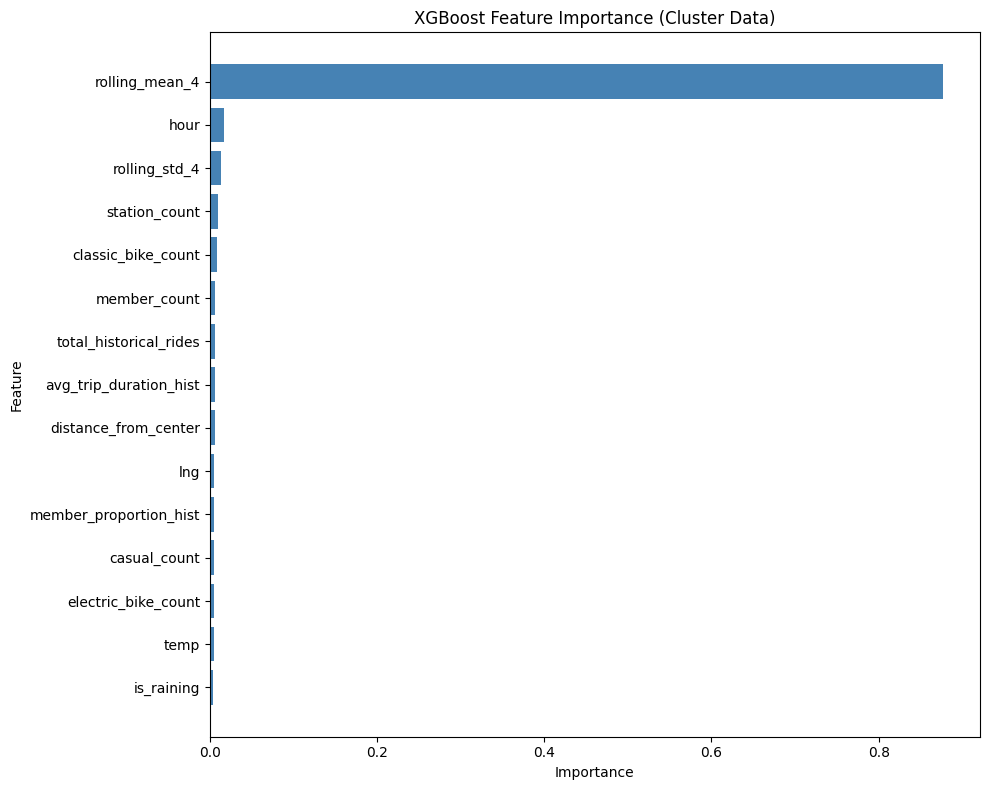

In [ ]:
# ============================================================
# FEATURE IMPORTANCE
# ============================================================

# Get feature importances - use X.columns (same as what model was trained on)
importances = xgb_cluster_model.feature_importances_
feature_names = X.columns  # Use X, not X_cluster

print(f"Number of features: {len(feature_names)}")
print(f"Number of importances: {len(importances)}")

# Create DataFrame and sort
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print("\nTop 15 Most Important Features:")
print("-"*40)
for idx, row in importance_df.head(15).iterrows():
    print(f"  {row['Feature']:<30} {row['Importance']:.4f}")

# Plot feature importance using matplotlib
plt.figure(figsize=(10, 8))
top_features = importance_df.head(15)
plt.barh(top_features['Feature'], top_features['Importance'], color='steelblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('XGBoost Feature Importance (Cluster Data)')
plt.gca().invert_yaxis()  # Highest importance at top
plt.tight_layout()
plt.show()

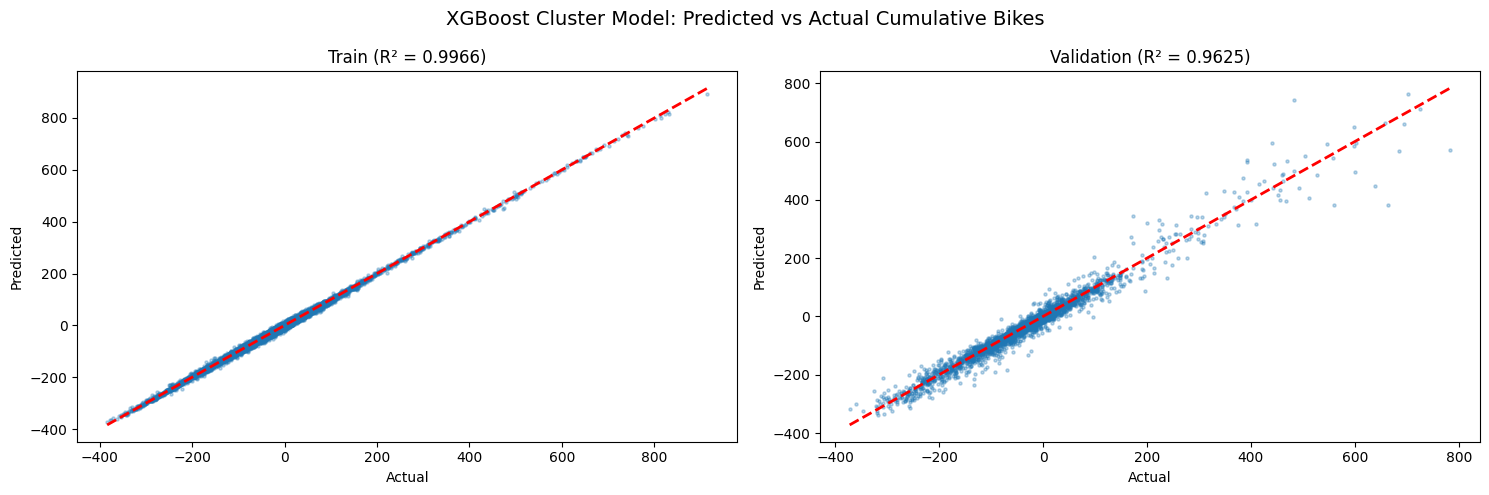

In [ ]:
# ============================================================
# PREDICTION VS ACTUAL VISUALIZATION
# ============================================================

# Create scatter plot of predicted vs actual
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Train
axes[0].scatter(y_train_cluster, y_train_pred, alpha=0.3, s=5)
axes[0].plot([y_train_cluster.min(), y_train_cluster.max()],
             [y_train_cluster.min(), y_train_cluster.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')
axes[0].set_title(f'Train (R² = {train_metrics["R²"]:.4f})')

# Validation
axes[1].scatter(y_val_cluster, y_val_pred, alpha=0.3, s=5)
axes[1].plot([y_val_cluster.min(), y_val_cluster.max()],
             [y_val_cluster.min(), y_val_cluster.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')
axes[1].set_title(f'Validation (R² = {val_metrics["R²"]:.4f})')

plt.suptitle('XGBoost Cluster Model: Predicted vs Actual Cumulative Bikes', fontsize=14)
plt.tight_layout()
plt.show()

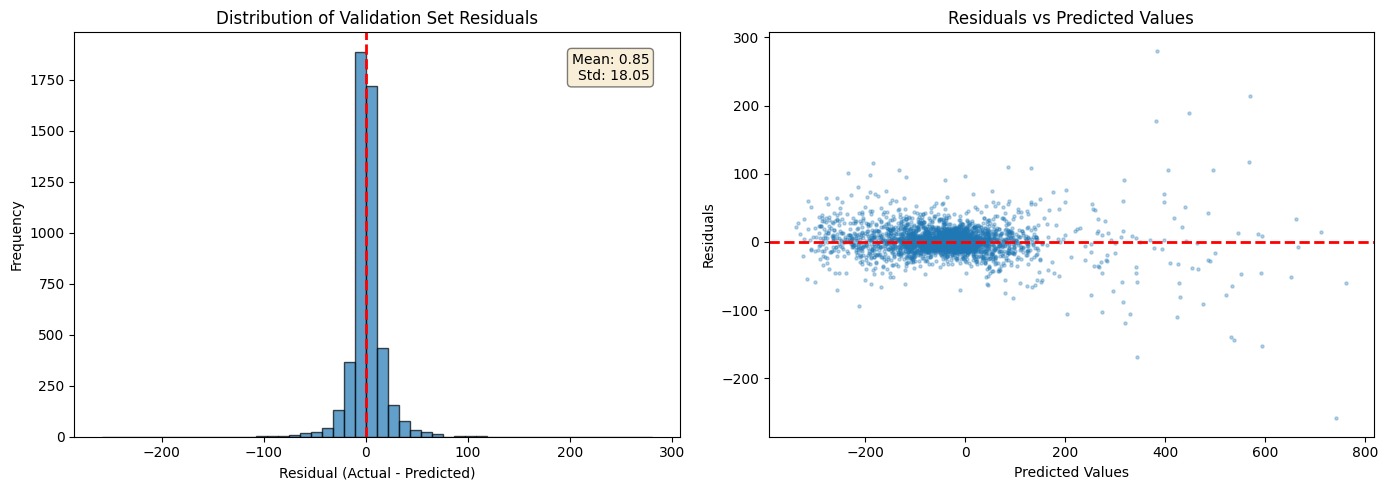


📊 Residual Statistics:
  Mean residual: 0.8505
  Std residual: 18.0468
  Min residual: -258.8137
  Max residual: 280.4629


In [ ]:
# ============================================================
# RESIDUAL ANALYSIS
# ============================================================

# Calculate residuals
Validation_residuals = y_val_cluster.values - y_val_pred

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Residual distribution
axes[0].hist(Validation_residuals, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Residual (Actual - Predicted)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Validation Set Residuals')
axes[0].text(0.95, 0.95, f'Mean: {np.mean(Validation_residuals):.2f}\nStd: {np.std(Validation_residuals):.2f}',
             transform=axes[0].transAxes, fontsize=10, verticalalignment='top',
             horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Residuals vs Predicted
axes[1].scatter(y_val_pred, Validation_residuals, alpha=0.3, s=5)
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted Values')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residuals vs Predicted Values')

plt.tight_layout()
plt.show()

# Check for bias
print(f"\n📊 Residual Statistics:")
print(f"  Mean residual: {np.mean(Validation_residuals):.4f}")
print(f"  Std residual: {np.std(Validation_residuals):.4f}")
print(f"  Min residual: {np.min(Validation_residuals):.4f}")
print(f"  Max residual: {np.max(Validation_residuals):.4f}")

In [ ]:
# ============================================================
# TIME SERIES PREDICTION COMPARISON
# ============================================================

# Get test set time intervals
#val_times = bike_changes_cluster_aggregated .iloc[val_end:]['time_interval'].reset_index(drop=True)
#val_clusters = bike_changes_cluster_aggregated .iloc[val_end:]['geo_cluster'].reset_index(drop=True)

# Plot for a specific cluster
#sample_cluster = val_clusters.unique()[0]  # First cluster
#mask = test_clusters == sample_cluster

#plt.figure(figsize=(14, 6))
#plt.plot(test_times[mask], y_test_cluster.reset_index(drop=True)[mask],
#         label='Actual', alpha=0.8, linewidth=1)
#plt.plot(test_times[mask], y_test_pred[mask],
#         label='Predicted', alpha=0.8, linewidth=1)
#plt.xlabel('Time')
#plt.ylabel('Cumulative Bikes')
#plt.title(f'XGBoost Predictions vs Actual for Cluster {sample_cluster}')
#plt.legend()
#plt.xticks(rotation=45)
#plt.tight_layout()
#plt.show()

#print(f"\n📈 Showing predictions for Cluster {sample_cluster}")
#print(f"   Time range: {test_times[mask].min()} to {test_times[mask].max()}")

In [ ]:
# ============================================================
# SUMMARY: CLUSTER MODEL PERFORMANCE
# ============================================================

# Original model performance (from hyperparameter search on station-level data)
original_rmse = (-xgb_search.best_score_)**0.5

print("="*60)
print("MODEL COMPARISON SUMMARY")
print("="*60)
print(f"\n📊 Station-Level Model (Original from hyperparameter search):")
print(f"   CV RMSE: {original_rmse:.4f}")

print(f"\n📊 Cluster-Level Model:")
print(f"   Train RMSE: {train_metrics['RMSE']:.4f}")
print(f"   Train MAE:  {train_metrics['MAE']:.4f}")
print(f"   Train R²:   {train_metrics['R²']:.4f}")
print(f"   Val RMSE:   {val_metrics['RMSE']:.4f}")
print(f"   Val MAE:    {val_metrics['MAE']:.4f}")
print(f"   Val R²:     {val_metrics['R²']:.4f}")

print(f"\n💡 Dataset Info:")
print(f"   - Total clusters: {bike_changes_cluster_aggregated['geo_cluster'].nunique()}")
print(f"   - Total rows: {len(bike_changes_cluster_aggregated):,}")
print(f"   - Features used: {X.shape[1]}")

print("\n✅ Model trained on cluster-aggregated data!")

MODEL COMPARISON SUMMARY

📊 Station-Level Model (Original from hyperparameter search):
   CV RMSE: 6.8551

📊 Cluster-Level Model:
   Train RMSE: 5.2722
   Train MAE:  3.9312
   Train R²:   0.9966
   Val RMSE:   18.0668
   Val MAE:    9.9435
   Val R²:     0.9625

💡 Dataset Info:
   - Total clusters: 99
   - Total rows: 24,853
   - Features used: 23

✅ Model trained on cluster-aggregated data!
